# Weapon Accuracy

## Setting Up

In [1]:
import pandas as pd
from scripts.probability import at_least_one

%run weapon_full_data.ipynb

# Accuracy Range

Soldiers start with an Accuracy value between 40 and 70. But the attribute may go up to 120. So we are going to prepare a set moving between 40 and 120.

As the average Accuracy for new soldiers is 55 we add this as one of the values.

In [2]:
data = []
for i in range(40, 121, 1):
    data.append(i)

accuracy_range = pd.DataFrame(data, columns = ["soldier_accuracy"])

## Merging With Weapons

In [3]:
weapon_attacks_proficiency = weapon_data.append([weapon_data] * (len(accuracy_range.index)-1), ignore_index=True)
weapon_attacks_proficiency["key"] = weapon_attacks_proficiency.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

weapon_attacks_proficiency = pd.merge(weapon_attacks_proficiency, accuracy_range, left_on="key", right_index=True, how="left", sort=False)
weapon_attacks_proficiency = weapon_attacks_proficiency.drop(columns=["key"])

## Final Accuracy

For our needs the accuracy formula is just the weapon accuracy multiplied by the soldier accuracy.

In [4]:
weapon_attacks_proficiency["chance_to_hit"] = weapon_attacks_proficiency.apply(lambda x: x["accuracy"] * x["soldier_accuracy"] / 10000, axis=1)
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,average_chance_to_hit,burst,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,clip_damage,damage_per_time_unit,soldier_accuracy,chance_to_hit
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,0.3300,1,3,4.0,78,25.740,312.0,1.444444,40,0.240
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,0.4290,1,2,6.0,52,22.308,312.0,0.866667,40,0.312
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,0.1925,3,2,10.0,60,11.550,600.0,0.857143,40,0.140
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,0.3300,1,2,10.0,60,19.800,600.0,1.200000,40,0.240
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,0.6050,1,1,20.0,30,18.150,600.0,0.375000,40,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,0.4675,1,1,255.0,110,51.425,28050.0,1.466667,120,1.020
4856,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,0.2750,1,2,127.5,220,60.500,28050.0,3.333333,120,0.600
4857,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,0.4675,1,2,127.5,220,102.850,28050.0,3.666667,120,1.020
4858,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,0.5500,1,1,255.0,110,60.500,28050.0,1.833333,120,1.200


# Weapon Accuracies On Average

In [5]:
weapon_proficiency_development_average = weapon_attacks_proficiency[["weapon", "fire_mode", "soldier_accuracy", "chance_to_hit"]]
weapon_proficiency_development_average = weapon_proficiency_development_average.groupby(["weapon", "soldier_accuracy"]).mean()
weapon_proficiency_development_average = weapon_proficiency_development_average.sort_values(by=["weapon"])
weapon_proficiency_development_average

chance_to_hit
weapon        soldier_accuracy               
alien_grenade 40                       0.2600
              98                       0.6370
              97                       0.6305
              96                       0.6240
              95                       0.6175
...                                       ...
stun_rod      63                       0.6300
              62                       0.6200
              61                       0.6100
              58                       0.5800
              120                      1.2000

[1863 rows x 1 columns]

## Kinetic Weapons

Text(0, 0.5, 'Final accuracy')

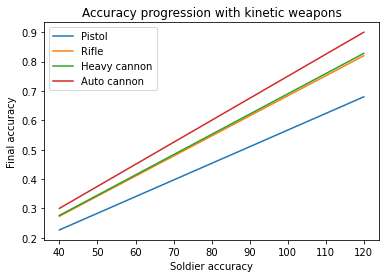

In [6]:
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average_kinetic.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average_kinetic.unstack(level=0)
ax = weapon_proficiency_development_average_kinetic.plot(title="Accuracy progression with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"])
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Melee

Text(0, 0.5, 'Final accuracy')

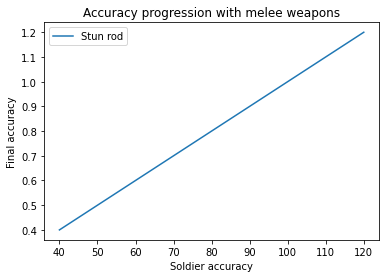

In [7]:
weapon_proficiency_development_average_melee = weapon_proficiency_development_average.loc[ ["stun_rod"] ]
weapon_proficiency_development_average_melee = weapon_proficiency_development_average_melee.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_melee = weapon_proficiency_development_average_melee.unstack(level=0)
ax = weapon_proficiency_development_average_melee.plot(title="Accuracy progression with melee weapons")
ax.legend(["Stun rod"])
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Explosive

Text(0, 0.5, 'Final accuracy')

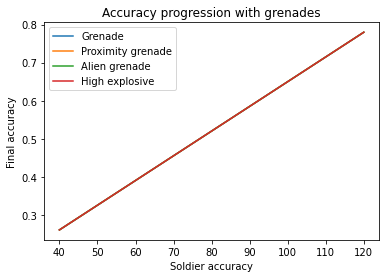

In [8]:
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average_grenade.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average_grenade.unstack(level=0)
ax = weapon_proficiency_development_average_grenade.plot(title="Accuracy progression with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"])
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

Text(0, 0.5, 'Final accuracy')

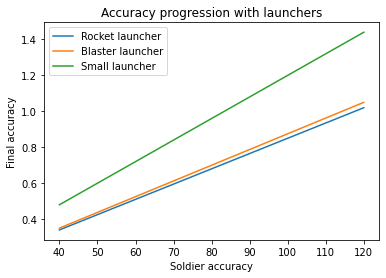

In [9]:
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average_launcher.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average_launcher.unstack(level=0)
ax = weapon_proficiency_development_average_launcher.plot(title="Accuracy progression with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"])
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Laser

Text(0, 0.5, 'Final accuracy')

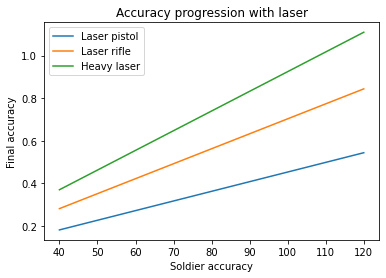

In [10]:
weapon_proficiency_development_average_laser = weapon_proficiency_development_average.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_proficiency_development_average_laser = weapon_proficiency_development_average_laser.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_laser = weapon_proficiency_development_average_laser.unstack(level=0)
ax = weapon_proficiency_development_average_laser.plot(title="Accuracy progression with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"])
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Plasma

Text(0, 0.5, 'Final accuracy')

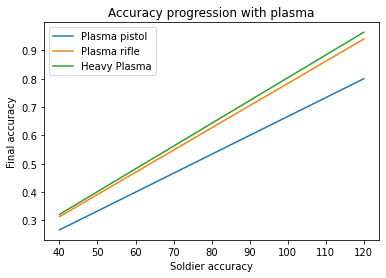

In [11]:
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average_plasma.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average_plasma.unstack(level=0)
ax = weapon_proficiency_development_average_plasma.plot(title="Accuracy progression with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Tank

Tanks don't increase skills. But the calculations are included.

Text(0, 0.5, 'Final accuracy')

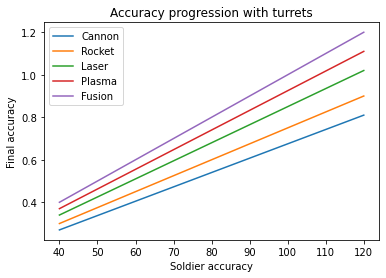

In [12]:
weapon_proficiency_development_average_turret = weapon_proficiency_development_average.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_proficiency_development_average_turret = weapon_proficiency_development_average_turret.sort_values(by=["chance_to_hit"])
weapon_proficiency_development_average_turret = weapon_proficiency_development_average_turret.unstack(level=0)
ax = weapon_proficiency_development_average_turret.plot(title="Accuracy progression with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

# At Least One Hit

Having the max number of shots a weapon can make on a turn. What is the chance of getting at least one hit?

In [13]:
weapon_attacks_proficiency["burst"] = weapon_attacks_proficiency.apply(burst, axis=1)
weapon_attacks_proficiency["turn_max_shots"] = weapon_attacks_proficiency.apply(max_shots, axis=1)
weapon_attacks_proficiency["at_least_one"] = weapon_attacks_proficiency.apply(lambda x: at_least_one(x["chance_to_hit"], x["turn_max_shots"]), axis=1)
weapon_attacks_proficiency["at_least_one"] = pd.to_numeric(weapon_attacks_proficiency["at_least_one"])
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,average_chance_to_hit,burst,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,clip_damage,damage_per_time_unit,soldier_accuracy,chance_to_hit,at_least_one
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,0.3300,1,3,4.0,78,25.740,312.0,1.444444,40,0.240,0.561024
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,0.4290,1,2,6.0,52,22.308,312.0,0.866667,40,0.312,0.526656
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,0.1925,3,2,10.0,60,11.550,600.0,0.857143,40,0.140,0.260400
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,0.3300,1,2,10.0,60,19.800,600.0,1.200000,40,0.240,0.422400
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,0.6050,1,1,20.0,30,18.150,600.0,0.375000,40,0.440,0.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,0.4675,1,1,255.0,110,51.425,28050.0,1.466667,120,1.020,1.000000
4856,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,0.2750,1,2,127.5,220,60.500,28050.0,3.333333,120,0.600,0.840000
4857,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,0.4675,1,2,127.5,220,102.850,28050.0,3.666667,120,1.020,1.000000
4858,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,0.5500,1,1,255.0,110,60.500,28050.0,1.833333,120,1.200,1.000000


## Averages

In [14]:
weapon_proficiency_development_one = weapon_attacks_proficiency[["weapon", "fire_mode", "soldier_accuracy", "at_least_one"]]
weapon_proficiency_development_one = weapon_proficiency_development_one.groupby(["weapon", "soldier_accuracy"]).mean()
weapon_proficiency_development_one = weapon_proficiency_development_one.sort_values(by=["weapon"])
weapon_proficiency_development_one

at_least_one
weapon        soldier_accuracy              
alien_grenade 40                      0.2600
              98                      0.6370
              97                      0.6305
              96                      0.6240
              95                      0.6175
...                                      ...
stun_rod      63                      0.8631
              62                      0.8556
              61                      0.8479
              58                      0.8236
              120                     1.0000

[1863 rows x 1 columns]

## Kinetic Weapons

Text(0, 0.5, 'At least 1 hit')

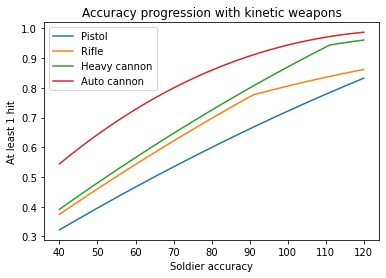

In [15]:
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one_kinetic.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one_kinetic.unstack(level=0)
ax = weapon_proficiency_development_one_kinetic.plot(title="Accuracy progression with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Melee

Text(0, 0.5, 'At least 1 hit')

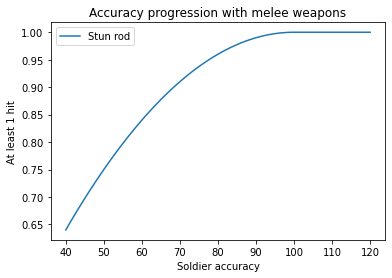

In [16]:
weapon_proficiency_development_one_melee = weapon_proficiency_development_one.loc[ ["stun_rod"] ]
weapon_proficiency_development_one_melee = weapon_proficiency_development_one_melee.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_melee = weapon_proficiency_development_one_melee.unstack(level=0)
ax = weapon_proficiency_development_one_melee.plot(title="Accuracy progression with melee weapons")
ax.legend(["Stun rod"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Explosive

Text(0, 0.5, 'At least 1 hit')

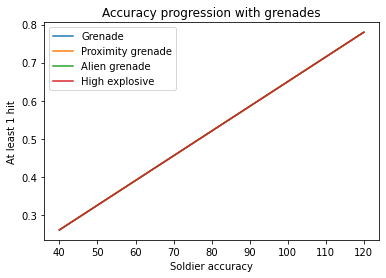

In [17]:
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one_grenade.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one_grenade.unstack(level=0)
ax = weapon_proficiency_development_one_grenade.plot(title="Accuracy progression with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

Text(0, 0.5, 'At least 1 hit')

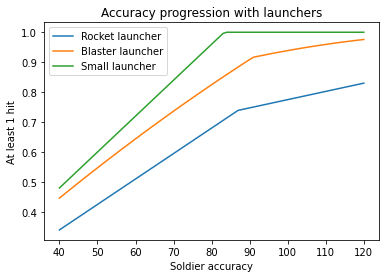

In [18]:
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one_launcher.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one_launcher.unstack(level=0)
ax = weapon_proficiency_development_one_launcher.plot(title="Accuracy progression with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Laser

Text(0, 0.5, 'At least 1 hit')

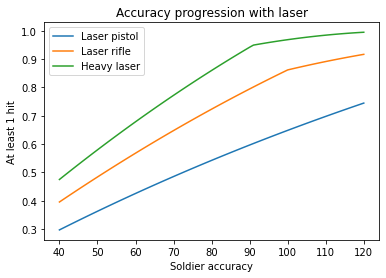

In [19]:
weapon_proficiency_development_one_laser = weapon_proficiency_development_one.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_proficiency_development_one_laser = weapon_proficiency_development_one_laser.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_laser = weapon_proficiency_development_one_laser.unstack(level=0)
ax = weapon_proficiency_development_one_laser.plot(title="Accuracy progression with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Plasma

Text(0, 0.5, 'At least 1 hit')

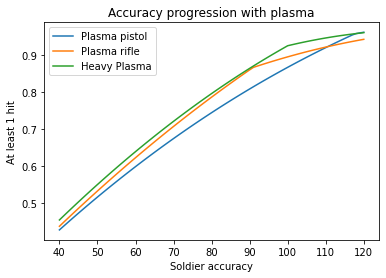

In [20]:
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one_plasma.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one_plasma.unstack(level=0)
ax = weapon_proficiency_development_one_plasma.plot(title="Accuracy progression with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Tank

Text(0, 0.5, 'At least 1 hit')

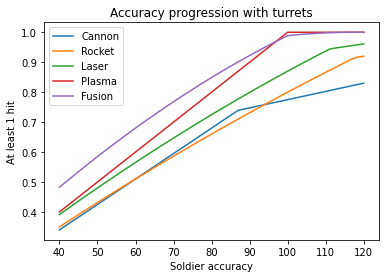

In [21]:
weapon_proficiency_development_one_turret = weapon_proficiency_development_one.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_proficiency_development_one_turret = weapon_proficiency_development_one_turret.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_turret = weapon_proficiency_development_one_turret.unstack(level=0)
ax = weapon_proficiency_development_one_turret.plot(title="Accuracy progression with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Weapon Accuracy Comparison

Using an average soldier Accuracy of 50.

### On Average

Text(0, 0.5, 'Chance to hit')

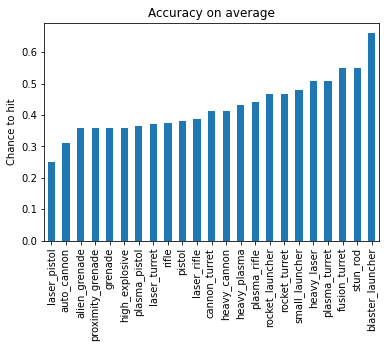

In [22]:
weapon_proficiency_development_average_middle = weapon_proficiency_development_average.xs(55, level="soldier_accuracy")
weapon_proficiency_development_average_middle = weapon_proficiency_development_average_middle.sort_values(by=["chance_to_hit"])
ax = weapon_proficiency_development_average_middle.plot.bar(title="Accuracy on average", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Chance to hit")

### At Least One

Text(0, 0.5, 'At least 1 hit')

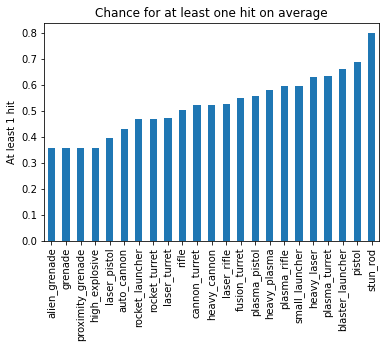

In [23]:
weapon_proficiency_development_one_middle = weapon_proficiency_development_one.xs(55, level="soldier_accuracy")
weapon_proficiency_development_one_middle = weapon_proficiency_development_one_middle.sort_values(by=["at_least_one"])
ax = weapon_proficiency_development_one_middle.plot.bar(title="Chance for at least one hit on average", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("At least 1 hit")